In [8]:
import datetime
import os
from uuid import UUID
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

from pot.network.node import SelfNodeInfo
from pot.network.storage import BlocksStorage, NodeStorage, TransactionStorage, NodeTrustStorage, ValidatorStorage, \
    TransactionVerifiedStorage
from pot.network.manager import NodeTrust

storage_path = os.path.realpath(os.path.join(os.path.dirname('.'), '..', 'storage'))
result_path = os.path.realpath(os.path.join(os.path.dirname('.'), '..', 'monitor', 'result'))

firsts_records = 100

load_dotenv()

True

In [9]:
def get_self_node_info(path: str) -> UUID:
    old_value = os.getenv('STORAGE_DIR')
    os.environ["STORAGE_DIR"] = path
    self_node = SelfNodeInfo(True)
    os.environ["STORAGE_DIR"] = old_value
    return self_node.identifier


def get_info_from_blockchain(path: str) -> dict:
    storage = BlocksStorage(path)
    blocks = storage.load()
    return {
        "len": len(blocks),
        "transaction_len": sum([len(block.transactions) for block in blocks])
    }


def get_info_from_nodes(path: str) -> dict:
    storage = NodeStorage(path)
    nodes = storage.load()
    trust = NodeTrust.__new__(NodeTrust)
    trust._storage = NodeTrustStorage(path)
    # trust._storage.load()
    # print(f"Trust from {path}: {trust._storage.load()}")
    # old_value = os.getenv('STORAGE_DIR')
    # os.putenv('STORAGE_DIR', path)
    # self_node = SelfNodeInfo()
    # os.putenv('STORAGE_DIR', old_value)
    return {
        "len": len(nodes),
        #"trust": trust.get_node_trust(self_node.get_node())
        "trust": trust._storage.load()
    }


def get_info_from_validators(path: str) -> dict:
    storage = ValidatorStorage(path)
    validators = storage.load()
    return {
        "len": len(validators),
        "validators": ','.join([v.hex for v in validators])
    }


def get_info_from_transactions_to_verify(path: str) -> dict:
    storage = TransactionStorage(path)
    try:
        txs = storage.load()
    except Exception as e:
        print(f"Error while processing path {path}: {e}")
        txs = []
    return {
        "len": len(txs)
    }


def get_info_from_transactions_verified(path: str) -> dict:
    storage = TransactionVerifiedStorage(path)
    txs = storage.load()
    return {
        "len": len(txs)
    }

In [10]:
cols_dict = {
    'time': 'Time',
    'number_of_nodes': 'Number of nodes',
    'number_of_validators': 'Number of validators',
    # 'node_trust': 'Node trust',
    'number_of_blocks': 'Number of blocks',
    'number_of_transaction_to_verify': 'Number of transactions to verify',
    'number_of_verified_transactions': 'Number of verified transactions',
    'validators': 'Validators'
}

cols = list(cols_dict.keys())

df_trust = pd.DataFrame(columns=["time", "sourceNode", "node", "trust"])
df_trust.set_index(["time", "sourceNode", "node"], inplace=True)
# df_trust.sort_index()

In [11]:
first_time = None
dfs = {}

nodes_mapping = {}

for node in os.listdir(storage_path):
    # list all nodes in dir

    if node == '.gitignore':
        continue

    print(f"Processing node {node}")

    trust_data = []

    df = pd.DataFrame(columns=cols)
    df.set_index('time', inplace=True)

    dirs = [int(time_dir) for time_dir in os.listdir(os.path.join(storage_path, node, 'dump'))]
    dirs.sort()
    print(f"Found {len(dirs)} dirs in node {node}")

    record_i = 0
    for time in dirs:
        # list all time in dir
        if not first_time:
            first_time = time

        if firsts_records is not None and firsts_records < record_i:
            break

        storage_dir = os.path.join(storage_path, node, 'dump', str(time))
        # print(f"Processing dir {storage_dir}")

        if node not in nodes_mapping.keys():
            self_node_id = get_self_node_info(storage_dir)
            nodes_mapping[node] = self_node_id.hex
            print(self_node_id.hex)

        try:
            #self_node_id = get_self_node_info(storage_dir)
            blocks_info = get_info_from_blockchain(storage_dir)
            nodes_info = get_info_from_nodes(storage_dir)
            validators_info = get_info_from_validators(storage_dir)
            txs_to_ver_info = get_info_from_transactions_to_verify(storage_dir)
            txs_ver_info = get_info_from_transactions_verified(storage_dir)
        except Exception as e:
            print(f"Exception {e} while loading from node: {node} from time {time}")
            raise e

        actual_time = time - first_time
        df.loc[actual_time] = [
            nodes_info['len'],
            validators_info['len'],
            # nodes_info["trust"],
            blocks_info['len'],
            txs_to_ver_info['len'],
            txs_ver_info['len'],
            validators_info["validators"]
        ]
        for node_id, trust in nodes_info["trust"].items():
            trust_data.append({
                "time": actual_time,
                "sourceNode": node,
                "node": node_id.hex,
                "trust": trust
            })
            # df_trust.loc[(actual_time, node, node_id.hex), :] = trust
        record_i += 1

    # check if all df has step by step info
    #df.to_excel(os.path.join(result_path, f"result-{node}.xlsx"))
    dfs[node] = df

    df_trust_node = pd.DataFrame(trust_data, columns=["time", "sourceNode", "node", "trust"])
    df_trust_node.set_index(["time", "sourceNode", "node"], inplace=True)
    #df_trust_node.to_excel(os.path.join(result_path, f"result-trust-{node}.xlsx"))

    df_trust = pd.concat([df_trust, df_trust_node])


Processing node e5ef6f3d6292
Found 1859 dirs in node e5ef6f3d6292
ab086f26851a46538805ad83d144fad6
Processing node 0a479aec6c60
Found 1880 dirs in node 0a479aec6c60
9b55ff3ca9b540778da0ff576f69cc10
Processing node b2af3cbba21d
Found 1889 dirs in node b2af3cbba21d
6c0d6727453640048d0ad5a977ac4ac6
Processing node 467bb1befdd6
Found 1863 dirs in node 467bb1befdd6
285b9ed67a214329af06e6a9ee5d28b2
Processing node cc2afc66a825
Found 1852 dirs in node cc2afc66a825
b8d9a3b6c6da4e2daa907687cfe4c978
Processing node 1af44b40863c
Found 1875 dirs in node 1af44b40863c
1592bdbb409f46d6ad0c1aa8e51b0360
Processing node 435c733f0ed0
Found 1868 dirs in node 435c733f0ed0
4d5cf72eb0a84162a85c26a5d0051079


In [12]:
for node, df in dfs.items():
    df.drop(columns=['validators'], inplace=True)

In [13]:
import itertools
nodes_ids = df_trust.reset_index()["node"].unique()

print("Nodes map")
pprint(nodes_mapping)
print("Nodes")
pprint(nodes_ids)

markers = ["1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]
line_styles = ['-', '--', ':', '-.']
styles = itertools.cycle([marker + line for marker in markers for line in line_styles])

Nodes map
{'0a479aec6c60': '9b55ff3ca9b540778da0ff576f69cc10',
 '1af44b40863c': '1592bdbb409f46d6ad0c1aa8e51b0360',
 '435c733f0ed0': '4d5cf72eb0a84162a85c26a5d0051079',
 '467bb1befdd6': '285b9ed67a214329af06e6a9ee5d28b2',
 'b2af3cbba21d': '6c0d6727453640048d0ad5a977ac4ac6',
 'cc2afc66a825': 'b8d9a3b6c6da4e2daa907687cfe4c978',
 'e5ef6f3d6292': 'ab086f26851a46538805ad83d144fad6'}
Nodes
array(['9b55ff3ca9b540778da0ff576f69cc10',
       '1592bdbb409f46d6ad0c1aa8e51b0360',
       '4d5cf72eb0a84162a85c26a5d0051079',
       '285b9ed67a214329af06e6a9ee5d28b2',
       'ab086f26851a46538805ad83d144fad6',
       'b8d9a3b6c6da4e2daa907687cfe4c978',
       '6c0d6727453640048d0ad5a977ac4ac6'], dtype=object)


Processing trust for node 1592bdbb409f46d6ad0c1aa8e51b0360 => 1af44b40863c


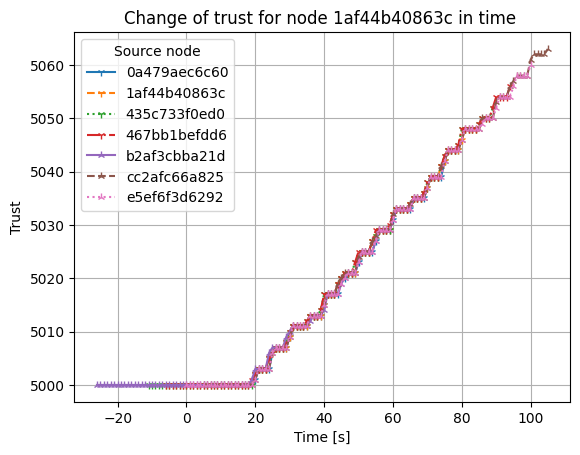

In [15]:
import random

node_id = random.choice(nodes_ids)

if node_id not in list(nodes_mapping.values()):
    print(f"{node_id} not found in nodes_mapping")
node_name = list(nodes_mapping.keys())[list(nodes_mapping.values()).index(node_id)]

print(f"Processing trust for node {node_id} => {node_name}")
# Plot trust for node - all
pivot = df_trust.xs(node_id, level=2).reset_index().pivot(index='time', columns='sourceNode', values='trust')
style_list = [next(styles) for _ in pivot.columns]
pivot.plot(
    style=style_list,
    legend=True,
    title=f"Change of trust for node {node_name} in time",
    xlabel="Time [s]",
    ylabel="Trust",
    grid=True
)
    # (df_trust.xs(node_id, level=2)
    #     .reset_index()
    #     .pivot(index='time', columns='sourceNode', values='trust')
    #     .plot(kind='line', figsize=(10, 6), style=style_list))
plt.title(f"Change of trust for node {node_name} in time ")
plt.xlabel('Time [s]')
plt.ylabel('Trust')
plt.legend(title='Source node')
plt.grid(True)
plt.savefig(os.path.join(result_path, f"plot-trust-{node_name}.png"))


In [24]:
import numpy as np
pivot.info()
while True:
    unique_trust = random.choice(pivot[random.choice(pivot.columns)].unique())
    if unique_trust is not np.nan:
        break
unique_trust

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, -26 to 105
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   0a479aec6c60  60 non-null     object
 1   1af44b40863c  65 non-null     object
 2   435c733f0ed0  101 non-null    object
 3   467bb1befdd6  101 non-null    object
 4   b2af3cbba21d  95 non-null     object
 5   cc2afc66a825  101 non-null    object
 6   e5ef6f3d6292  101 non-null    object
dtypes: object(7)
memory usage: 8.2+ KB


5013

In [25]:
import numpy as np
while True:
    random_column = random.choice(pivot.columns)
    random_trust = random.choice(pivot[random_column].unique())
    if random_trust is not np.nan:
        break

print("Trust: " + str(int(random_trust)))
first_idx = pivot[pivot.index == random_trust].first_valid_index()
print("First index: " + str(int(first_idx)))

Trust: 5007


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [7]:
pivot = pivot.loc[first_idx - 5:first_idx + 5]
style_list = [next(styles) for _ in pivot.columns]
pivot.plot(
    style=style_list,
    legend=True,
    title=f"Change of trust for node {node_name} in time - change near {first_idx} second",
    xlabel="Time [s]",
    ylabel="Trust",
    grid=True
)
plt.legend(title='Source node')
plt.grid(True)
plt.savefig(os.path.join(result_path, f"plot-trust-{node_name}-part.png"))

1866

Index 0 for validators 6c0d6727453640048d0ad5a977ac4ac6
Index 19 for validators 1592bdbb409f46d6ad0c1aa8e51b0360,285b9ed67a214329af06e6a9ee5d28b2
Index 175 for validators 6c0d6727453640048d0ad5a977ac4ac6,9b55ff3ca9b540778da0ff576f69cc10
Index 328 for validators 4d5cf72eb0a84162a85c26a5d0051079,b8d9a3b6c6da4e2daa907687cfe4c978
Index 485 for validators ab086f26851a46538805ad83d144fad6,4d5cf72eb0a84162a85c26a5d0051079
